# Lazy FCA (Pasha Perevedentsev)

In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import warnings
warnings.filterwarnings("ignore")

Now, define several functions for loading and processing data

In [28]:
def load_connect_4(frac=0.05):
    data = pd.read_csv('../data_sets/connect-4/connect-4.data', header=None, index_col=False).sample(frac=frac)
    data = data[data[42] != 'draw'].reset_index(drop=True)
    data.ix[data[42] == 'win', 42] = 1
    data.ix[data[42] == 'loss', 42] = 0
    X = pd.concat(map(lambda x: pd.get_dummies(data[x]), data.drop([42], axis=1)), axis=1)
    y = data[42].astype(int)
    return X, y

def load_hayes_roth():
    data = pd.read_csv('hayes-roth.data.txt', header=None, index_col=0)
    data = data.reset_index(drop=True)
    data.ix[data[5] == 1, 5] = 0
    data.ix[(data[5] == 2) | (data[5] == 3), 5] = 1
    X = pd.concat(map(lambda x: pd.get_dummies(data[x]), data.drop([5], axis=1)), axis=1)
    y = data[5].astype(int)
    return X, y

Now, we must calculate some features. I've decided to use following ones: 
- Power of intersection with positive context
- Power of intersection with negative context
- Scaled support
- Scaled confidence

In [4]:
def learn(X, y, name = 'default'):
    foldation = KFold(X.shape[0], k, shuffle=True, random_state=seed)

    pos_arr = []
    neg_arr = []
    support_pos_arr = []
    confidence_pos_arr = []
    support_neg_arr = []
    confidence_neg_arr = []
    y_test_arr = []

    for fold_index, fold in enumerate(foldation):
        X_train = X.ix[fold[0]].values
        y_train = y.ix[fold[0]].values
        X_test = X.ix[fold[1]].values
        y_test = y.ix[fold[1]].astype(int).values

        X_train_pos = X_train[y_train == 1]
        X_train_neg = X_train[y_train == 0]

        for test_index, test_obj in enumerate(X_test):
            pos = np.sum(test_obj == X_train_pos) / (float(len(X_train_pos)) * X.shape[1])
            neg = np.sum(test_obj == X_train_neg) / (float(len(X_train_neg)) * X.shape[1])
            support_pos = 0
            support_neg = 0
            confidence_pos = 0
            confidence_neg = 0
            for train_obj in X_train_pos:
                intersection = (test_obj == train_obj)
                support_pos += (train_obj[intersection] == X_train_pos[:, intersection]).all(axis=1).sum() - 1
                confidence_pos += (train_obj[intersection] == X_train_neg[:, intersection]).all(axis=1).sum()
            for train_obj in X_train_neg:
                intersection = (test_obj == train_obj)
                support_neg += (train_obj[intersection] == X_train_neg[:, intersection]).all(axis=1).sum() - 1
                confidence_neg += (train_obj[intersection] == X_train_pos[:, intersection]).all(axis=1).sum()
            pos_arr.append(pos)
            neg_arr.append(neg)
            support_pos_arr.append(support_pos/(float(len(X_train_pos))**2))
            support_neg_arr.append(support_neg/(float(len(X_train_neg))**2))
            confidence_pos_arr.append(confidence_pos/(float(len(X_train_pos))*float(len(X_train_neg))))
            confidence_neg_arr.append(confidence_neg/(float(len(X_train_neg))*float(len(X_train_pos))))
        y_test_arr.extend(y_test)

    np.save("raw/pos-{}.npy".format(name), pos_arr)
    np.save("raw/neg-{}.npy".format(name), neg_arr)
    np.save("raw/support_pos-{}.npy".format(name), support_pos_arr)
    np.save("raw/support_neg-{}.npy".format(name), support_neg_arr)
    np.save("raw/confidence_pos-{}.npy".format(name), confidence_pos_arr)
    np.save("raw/confidence_neg-{}.npy".format(name), confidence_neg_arr)
    np.save("raw/y-{}.npy".format(name), y_test_arr)

Let's keep results in separate files

In [33]:
X, y = load_connect_4()
learn(X, y)

In [6]:
name = 'default'
pos_arr = np.load("raw/pos-{}.npy".format(name))
neg_arr = np.load("raw/neg-{}.npy".format(name))
support_pos_arr = np.load("raw/support_pos-{}.npy".format(name))
support_neg_arr = np.load("raw/support_neg-{}.npy".format(name))
confidence_pos_arr = np.load("raw/confidence_pos-{}.npy".format(name))
confidence_neg_arr = np.load("raw/confidence_neg-{}.npy".format(name))
y_test = np.load("raw/y-{}.npy".format(name))

Now we are going to test different features against its predictive accuracy, precision and recall.

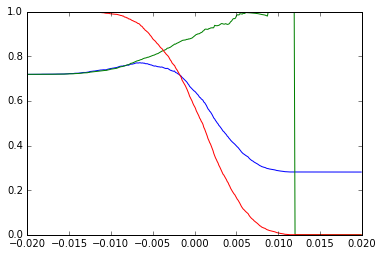

In [23]:
acc = []
prec = []
rec = []
r = np.arange(-0.02, 0.02, 0.0001)
for border in r:
    y_pred = ((pos_arr - neg_arr > border)).astype(int)
    acc.append(accuracy_score(y_test, y_pred))
    prec.append(precision_score(y_test, y_pred))
    rec.append(recall_score(y_test, y_pred))
a = plt.plot(r, acc, label='acc')
p = plt.plot(r, prec, label='prec')
r = plt.plot(r, rec, label='rec')

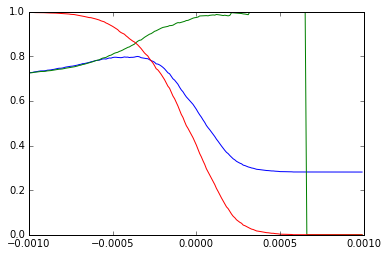

In [20]:
acc = []
prec = []
rec = []
r = np.arange(-0.001, 0.001, 0.00001)
for border in r:
    y_pred = ((support_pos_arr - support_neg_arr > border)).astype(int)
    acc.append(accuracy_score(y_test, y_pred))
    prec.append(precision_score(y_test, y_pred))
    rec.append(recall_score(y_test, y_pred))
plt.plot(r, acc, label='acc')
plt.plot(r, prec, label='prec')
plt.plot(r, rec, label='rec')

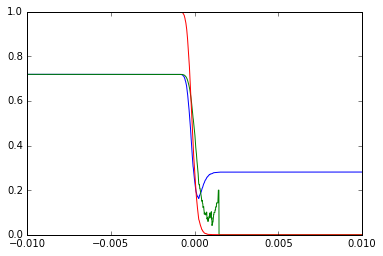

In [24]:
acc = []
prec = []
rec = []
r = np.arange(-0.01, 0.01, 0.00001)
for border in r:
    y_pred = ((confidence_pos_arr - confidence_neg_arr > border)).astype(int)
    acc.append(accuracy_score(y_test, y_pred))
    prec.append(precision_score(y_test, y_pred))
    rec.append(recall_score(y_test, y_pred))
plt.plot(r, acc, label='acc')
plt.plot(r, prec, label='prec')
plt.plot(r, rec, label='rec')

We can see that using power is the most predictable way to do something here

In [94]:
def online(X_train, y_train, X_test, y_test, border):
    acc = []
    prec = []
    rec = []
    X_train = X_train.values
    y_train = y_train.values
    X_test = X_test.values
    y_test = y_test.values
    X_train_pos = X_train[y_train == 1]
    X_train_neg = X_train[y_train == 0]
    y_pred = []
    for test_obj in X_test:
        pos = np.sum(test_obj == X_train_pos) / (float(len(X_train_pos)) * X_train.shape[1])
        neg = np.sum(test_obj == X_train_neg) / (float(len(X_train_neg)) * X_train.shape[1])
        y_pred.append(int(pos - neg > border))

    print("Accuracy: {}\nPrecision: {}\n"
          "Recall: {}".format(accuracy_score(y_test, y_pred),
                              precision_score(y_test, y_pred),
                              recall_score(y_test, y_pred)))

We've got a problem that that fixed border is too sensitive and on some subsets can be totally lefter or righter than actual border.

In [113]:
X_online_test, y_online_test = load_connect_4(0.1)
online(X, y, X_online_test, y_online_test, border=-0.0045)

Accuracy: 0.7627975220084774
Precision: 0.812396006655574
Recall: 0.8759811616954474
